## Mass Action Model
Mass action models are the most commonly used models to describe the dynamics of many biological systems. They provide a higher-dimensional (more variables) but simple framework. They involve low-order interactions (typically linear or quadratic since they rely on the law of mass action ). The model used here is developed by Hopkins et al. , which explains the oscillatory behavior of the early embryonic cell cycle of *Xenopus laevis* based on mass action type interactions. The equations governing this model are:

$$
\begin{align}
    \frac{du}{dt} &= k_{p,a}(A_T - u)v - k_{d,a}u(P_T - y), \\
    \frac{dv}{dt} &= k_s - b_\text{deg}uv, \\
    \frac{dw}{dt} &= k_{p,g}(G_T - w)v - k_{d,g}(P_T - y)w, \\
    \frac{dx}{dt} &= -k_{p,e}xw + k_\text{cat}y, \\
    \frac{dy}{dt} &= k_\text{ass}(E_T - x - y)(P_T - y) - k_\text{diss}y - k_\text{cat}y.
\end{align}
$$

This model consists of six interacting molecules, namely $u$, $v$, $w$, $x$, and $y$.  

### Parameters

- $ k_{p,a} = 0.4 $
- $ k_{d,a} = 100 $
- $ k_{p,g} = 0.05 $
- $ k_{diss} = 1 $
- $ k_{d,g} = 20 $
- $ k_{p,e} = 6 $
- $ k_{cat} = 4.5 $
- $ k_{ass} = 100 $
- $ k_s = 1.5 $
- $ b_{deg} = 0.1 $
- $ A_T = 1 $
- $ P_T = 1 $
- $ G_T = 1 $
- $ E_T = 3 $


In [1]:
import os, sys
print(sys.version)
print("_"* 60)
print(sys.executable)
print("_"* 60)

3.10.13 | packaged by conda-forge | (main, Dec 23 2023, 15:36:39) [GCC 12.3.0]
____________________________________________________________
/home/alka23224/miniconda3/envs/implicit_sindy/bin/python
____________________________________________________________


In [2]:
os.environ["PATH"] = ("/home/alka23224/miniconda3/envs/implicit_sindy/bin:" + os.environ["PATH"])

In [3]:
# -------------------------------
# Current working directory
# -------------------------------
current_dir = os.getcwd()
print(f"Current working directory: {current_dir}")


Current working directory: /home/alka23224/Chapter_5_SINDy


In [4]:
# -------------------------------
# Create a Folder for Plots
# -------------------------------
plot_dir = os.path.join(current_dir, "Plots")
os.makedirs(plot_dir, exist_ok=True) 

In [5]:
# -----------------------------
# Import Necessary Libraries
# -----------------------------
import numpy as np
import pandas as pd
import pysindy as ps
import sympy as sp
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import colors
from matplotlib.ticker import LogFormatter
import plotly.graph_objects as go
from sympy import symbols, Eq, solve, Matrix, N, simplify, nsimplify
from IPython.display import display
from IPython.display import Image
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
from pysindy.differentiation import SmoothedFiniteDifference
from pysindy.feature_library import CustomLibrary
from sklearn.metrics import mean_squared_error, r2_score
from tqdm.notebook import tqdm


In [6]:
import warnings
# Ignore all UserWarnings
warnings.filterwarnings("ignore", category=UserWarning)


In [7]:
# Import helper
from plot_utils import set_plot_style, set_spines_black, set_spines_black_3d
from symbolic_parser import build_expr_map, build_symbolic_rhs
from steady_states import find_steady_states
from network_utils import draw_network

In [8]:
# -------------------------------------------
# Define symbolic variable and parameters
# -------------------------------------------
# Define variables
u, v, w, x, y = sp.symbols('u v w x y')
# Parameter values
kpa, kda, kpg, kdiss, kdg = 0.4, 100, 0.05, 1, 20
kpe, kcat, kass, ks = 6, 4.5, 100, 1.5
bdeg, AT, PT, GT, ET = 0.1, 1, 1, 1, 3
# Define the ODEs
du_dt = kpa*(AT - u)*v - kda*u*(PT - y)
dv_dt = ks - bdeg*u*v
dw_dt = kpg*(GT - w)*v - kdg*(PT - y)*w
dx_dt = -kpe*x*w + kcat*y
dy_dt = kass*(ET - x - y)*(PT - y) - kdiss*y - kcat*y

# Display the ODEs
print("du/dt =", sp.expand(du_dt))
print("dv/dt =", sp.expand(dv_dt))
print("dw/dt =", sp.expand(dw_dt))
print("dx/dt =", sp.expand(dx_dt))
print("dy/dt =", sp.expand(dy_dt))

du/dt = -0.4*u*v + 100*u*y - 100*u + 0.4*v
dv/dt = -0.1*u*v + 1.5
dw/dt = -0.05*v*w + 0.05*v + 20*w*y - 20*w
dx/dt = -6*w*x + 4.5*y
dy/dt = 100*x*y - 100*x + 100*y**2 - 405.5*y + 300


In [9]:
# Define the Mass Action model
def mass_action_model(state, t, params):
    u, v, w, x, y = state 
    (kpa, kda, kpg, kdiss, kdg, kpe, kcat, kass, ks, bdeg, AT, PT, GT, ET)=params
    # Define the ODEs
    du_dt = kpa*(AT - u)*v - kda*u*(PT - y)
    dv_dt = ks - bdeg*u*v
    dw_dt = kpg*(GT - w)*v - kdg*(PT - y)*w
    dx_dt = -kpe*x*w + kcat*y
    dy_dt = kass*(ET - x - y)*(PT - y) - kdiss*y - kcat*y
    return [du_dt, dv_dt, dw_dt, dx_dt, dy_dt]
# Parameters
params = [0.4, 100, 0.05, 1, 20, 6, 4.5, 100, 1.5, 0.1, 1, 1, 1, 3]

In [10]:
## Training data 
# Parameters for ODE Integrator 
t0 = 0
tf_train= 100 # Maximum time for the simulation
dt = 0.001  # The time step
t_train= np.arange(t0,tf_train+dt,dt) # Time points for simulation
x0_train = [0, 0, 0, 3, 0]  # Initial state of the system
# Solve the system of ODEs
x_train = odeint(mass_action_model, x0_train, t_train, args=(params,))

In [11]:
## Test Data
# Parameters for ODE Integrator 
tf_test = 50  # Maximum time for the simulation
dt = 0.001  # Time step
t_test = np.arange(0, tf_test, dt)  # Time points for simulation
x0_test = [0.1, 0.2, 0, 3.5, 0]  # Initial state of the system
# Solve the system of ODEs
x_test = odeint(mass_action_model, x0_test, t_test, args=(params,))

In [12]:
# -----------------------------------
# To fit SINDy model using x_train
# -----------------------------------

In [13]:
model = ps.SINDy()
print(model)

SINDy(differentiation_method=FiniteDifference(axis=-2),
      feature_library=PolynomialLibrary(), optimizer=STLSQ())


In [14]:
## Create SINDy object

In [15]:
# 1) Differentiation Method
differentiation_method =SmoothedFiniteDifference()

In [16]:
# 2) Feature Library 
# -----------------------------------
#  Create library : Theta(x)
# -----------------------------------
# [Terms Present in the ODEs]
library = [
    lambda u, v, w, x, y: 1,
    lambda u, v, w, x, y: u,
    lambda u, v, w, x, y: v,
    lambda u, v, w, x, y: w,
    lambda u, v, w, x, y: x,
    lambda u, v, w, x, y: y,
    lambda u, v, w, x, y: u * v,
    lambda u, v, w, x, y: u * y,
    lambda u, v, w, x, y: v * w,
    lambda u, v, w, x, y: w * x,
    lambda u, v, w, x, y: w * y,
    lambda u, v, w, x, y: x * y,
    lambda u, v, w, x, y: y**2]

library_names = [
    lambda u, v, w, x, y: "1",
    lambda u, v, w, x, y: "u",
    lambda u, v, w, x, y: "v",
    lambda u, v, w, x, y: "w",
    lambda u, v, w, x, y: "x",
    lambda u, v, w, x, y: "y",
    lambda u, v, w, x, y: "uv",
    lambda u, v, w, x, y: "uy",
    lambda u, v, w, x, y: "vw",
    lambda u, v, w, x, y: "wx",
    lambda u, v, w, x, y: "wy",
    lambda u, v, w, x, y: "xy",
    lambda u, v, w, x, y: "y^2"]
custom_library = ps.CustomLibrary(
    library_functions=library,
    function_names=library_names).fit(x_train)

In [17]:
print(custom_library.get_feature_names())

['1', 'u', 'v', 'w', 'x', 'y', 'uv', 'uy', 'vw', 'wx', 'wy', 'xy', 'y^2']


In [18]:
# For alpha (regularization strength)
alphas = np.logspace(-20, -1, num=20)  
# For threshold (sparsity cutoff)
thresholds = [0.001, 0.002, 0.005, 0.01, 0.025]
# Initialize a matrix to store scores
scores = np.zeros((len(alphas), len(thresholds)))

# Perform Grid Search
for i, alpha in enumerate(tqdm(alphas, desc="Alpha values")):
    # inner tqdm for thresholds; leave=False to not clutter the console
    for j, threshold in enumerate(tqdm(thresholds, desc="Thresholds", leave=False)):
        sindy_optimizer = ps.STLSQ(
            threshold=threshold,
            alpha=alpha,
            max_iter=5000,
            normalize_columns=True
        )
        model = ps.SINDy(
            optimizer=sindy_optimizer,
            feature_library=custom_library,
            feature_names=["u","v","w","x","y"]
        )
        model.fit(x_train, t=dt)
        scores[i, j] = model.score(x_test, t=dt)

print('Grid search complete!')

Alpha values:   0%|          | 0/20 [00:00<?, ?it/s]

Thresholds:   0%|          | 0/5 [00:00<?, ?it/s]

Thresholds:   0%|          | 0/5 [00:00<?, ?it/s]

Thresholds:   0%|          | 0/5 [00:00<?, ?it/s]

Thresholds:   0%|          | 0/5 [00:00<?, ?it/s]

Thresholds:   0%|          | 0/5 [00:00<?, ?it/s]

Thresholds:   0%|          | 0/5 [00:00<?, ?it/s]

Thresholds:   0%|          | 0/5 [00:00<?, ?it/s]

Thresholds:   0%|          | 0/5 [00:00<?, ?it/s]

Thresholds:   0%|          | 0/5 [00:00<?, ?it/s]

Thresholds:   0%|          | 0/5 [00:00<?, ?it/s]

Thresholds:   0%|          | 0/5 [00:00<?, ?it/s]

Thresholds:   0%|          | 0/5 [00:00<?, ?it/s]

Thresholds:   0%|          | 0/5 [00:00<?, ?it/s]

Thresholds:   0%|          | 0/5 [00:00<?, ?it/s]

Thresholds:   0%|          | 0/5 [00:00<?, ?it/s]

Thresholds:   0%|          | 0/5 [00:00<?, ?it/s]

Thresholds:   0%|          | 0/5 [00:00<?, ?it/s]

Thresholds:   0%|          | 0/5 [00:00<?, ?it/s]

Thresholds:   0%|          | 0/5 [00:00<?, ?it/s]

Thresholds:   0%|          | 0/5 [00:00<?, ?it/s]

Grid search complete!


In [19]:
# Find the best hyperparameters
best_score = np.max(scores)
best_idx = np.unravel_index(np.argmax(scores), scores.shape)
best_alpha = alphas[best_idx[0]]
best_threshold = thresholds[best_idx[1]]

# Print the best hyperparameters and score
print(f"Optimal alpha: {best_alpha:.1e}")
print(f"Optimal threshold: {best_threshold:.1e}")
print(f"Optimal score:{best_score:.6f}")

Optimal alpha: 1.0e-14
Optimal threshold: 2.5e-02
Optimal score:0.999999


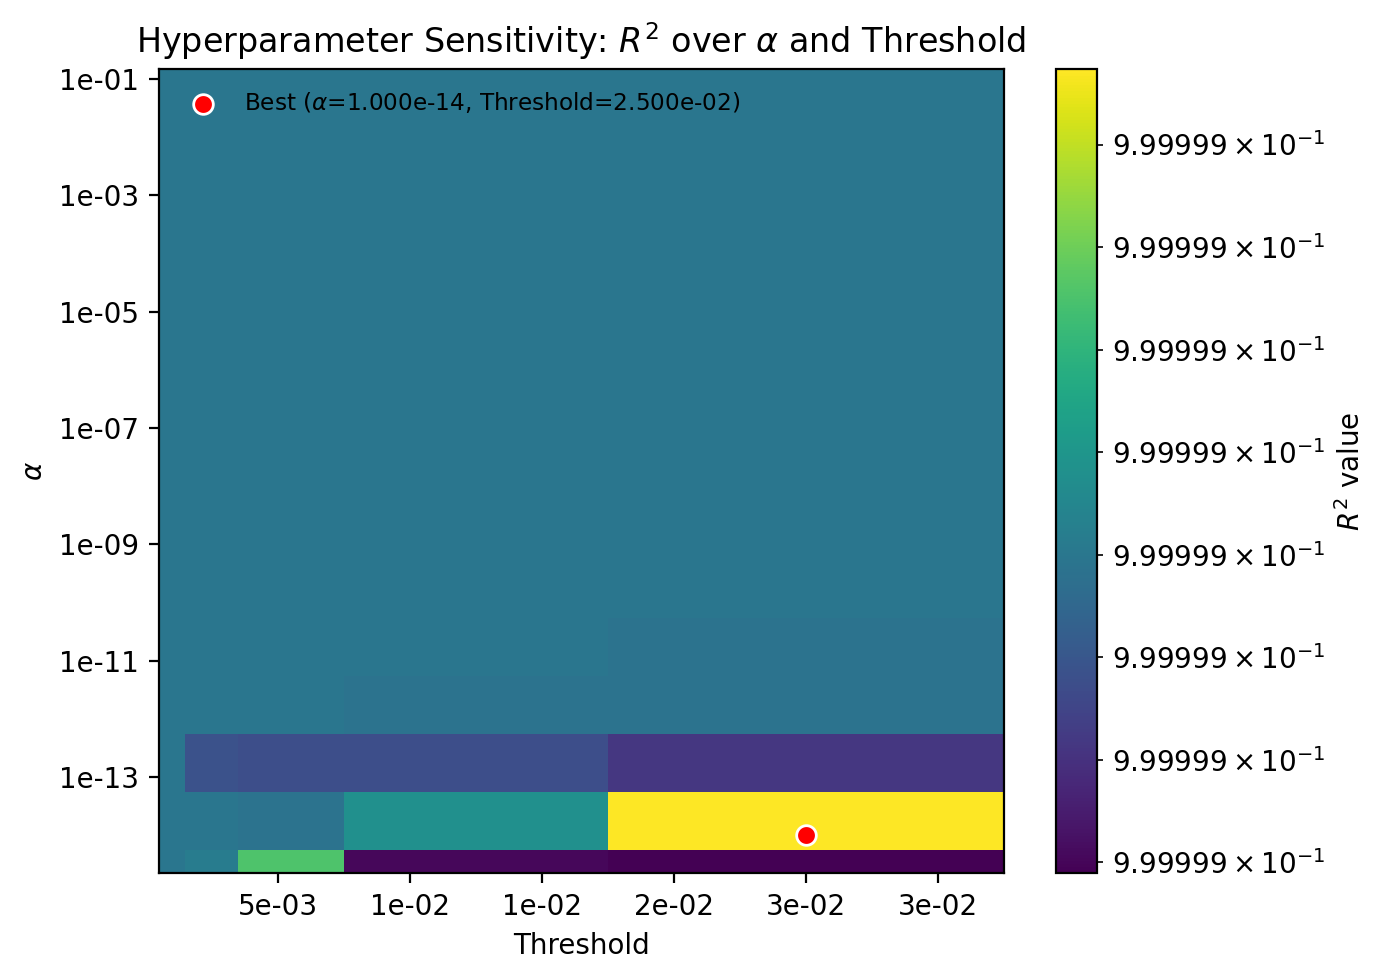

In [20]:
#####################################################
# Plot the Heatmap of R square Scores
plt.figure(figsize=(7, 5), dpi=200)

# Draw the heatmap 
X, Y = np.meshgrid(thresholds, alphas)
mesh = plt.pcolormesh(
    X, Y, scores,
    norm=colors.LogNorm(vmin=scores.min(), vmax=scores.max()),
    cmap='viridis',
    shading='auto'
)

cbar = plt.colorbar(mesh, label="$R^2$ value", format=LogFormatter())
cbar.ax.yaxis.set_tick_params(labelsize='small')
ax = plt.gca()
# ax.set_xscale('log')
ax.set_yscale('log')
ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%.0e'))
ax.yaxis.set_major_formatter(plt.FormatStrFormatter('%.0e'))

# Mark the optimal
plt.scatter(
    best_threshold, best_alpha,
    color='red', s=50, edgecolor='white',
    label=f'Best ($\\alpha$={best_alpha:.3e}, Threshold={best_threshold:.3e})'
)

# Labels, title, legend
plt.xlabel("Threshold", fontsize='medium')
plt.ylabel("$\\alpha$", fontsize='medium')
plt.title("Hyperparameter Sensitivity: $R^2$ over $\\alpha$ and Threshold", fontsize='large')

plt.legend(
    loc='upper left',
    frameon=False,
    fontsize='small'
)

plt.tight_layout()
# plt.savefig("heatmap_r2.pdf", bbox_inches="tight")
plt.show()


In [21]:
# Refit the Model with the Optimal Hyperparameters
## Define the Optimizer
sindy_optimizer = ps.STLSQ(
    threshold= best_threshold,
    alpha = best_alpha,
    max_iter=5000,
    normalize_columns=False
)
## Initialize the SINDy model
model = ps.SINDy(
    optimizer=sindy_optimizer,
    feature_library=custom_library,
    feature_names=["u","v","w","x","y"]
)
## Fit the SINDy model
model.fit(x_train, t=dt)

# Print the Learned Equations
print("The equations learned using SINDy:")
model.print(lhs=["du/dt","dv/dt","dw/dt","dx/dt","dy/dt"])

The equations learned using SINDy:
du/dt = -100.000 u + 0.400 v + -0.400 uv + 100.000 uy
dv/dt = 1.500 1 + -0.100 uv
dw/dt = 0.050 v + -20.000 w + -0.050 vw + 20.000 wy
dx/dt = 4.500 y + -6.000 wx
dy/dt = 300.000 1 + -100.000 x + -405.500 y + 100.000 xy + 100.000 y^2


In [22]:
# du/dt = -0.4*u*v + 100*u*y - 100*u + 0.4*v
# dv/dt = -0.1*u*v + 1.5
# dw/dt = -0.05*v*w + 0.05*v + 20*w*y - 20*w
# dx/dt = -6*w*x + 4.5*y
# dy/dt = 100*x*y - 100*x + 100*y**2 - 405.5*y + 300

In [23]:
print('The total number of terms present in the model:', model.complexity)

The total number of terms present in the model: 17


In [24]:
candidate_name = custom_library.get_feature_names()
sindy_coefficients = np.round(model.coefficients(),3)
sindy_results =pd.DataFrame(sindy_coefficients,
                                 index=["du/dt","dv/dt","dw/dt","dx/dt","dy/dt"],
                                 columns=candidate_name)
# Display the DataFrame
print("SINDy Results:")
print(sindy_results)

SINDy Results:
           1      u     v     w      x      y   uv     uy    vw   wx    wy  \
du/dt    0.0 -100.0  0.40   0.0    0.0    0.0 -0.4  100.0  0.00  0.0   0.0   
dv/dt    1.5    0.0  0.00   0.0    0.0    0.0 -0.1    0.0  0.00  0.0   0.0   
dw/dt    0.0    0.0  0.05 -20.0    0.0    0.0  0.0    0.0 -0.05  0.0  20.0   
dx/dt    0.0    0.0  0.00   0.0    0.0    4.5  0.0    0.0  0.00 -6.0   0.0   
dy/dt  300.0    0.0  0.00   0.0 -100.0 -405.5  0.0    0.0  0.00  0.0   0.0   

          xy    y^2  
du/dt    0.0    0.0  
dv/dt    0.0    0.0  
dw/dt    0.0    0.0  
dx/dt    0.0    0.0  
dy/dt  100.0  100.0  


In [25]:
# Simulate using the learned model
x_train_simulated = model.simulate(x_train[0], t_train)

In [26]:
forward_time = np.arange(0, tf_train+100, dt)
x_train_simulated_forward = model.simulate(x_train[0], forward_time)

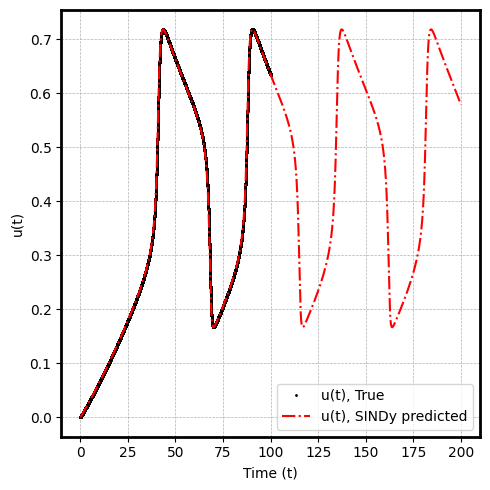

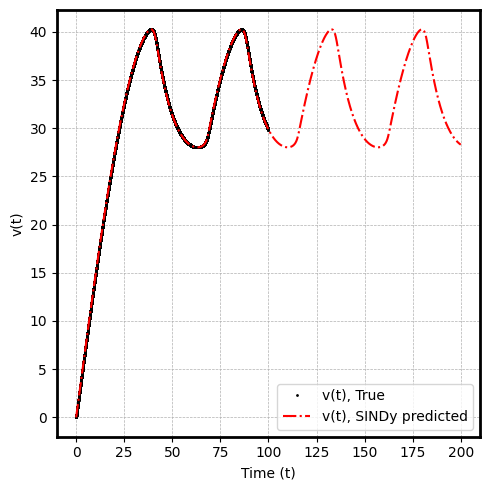

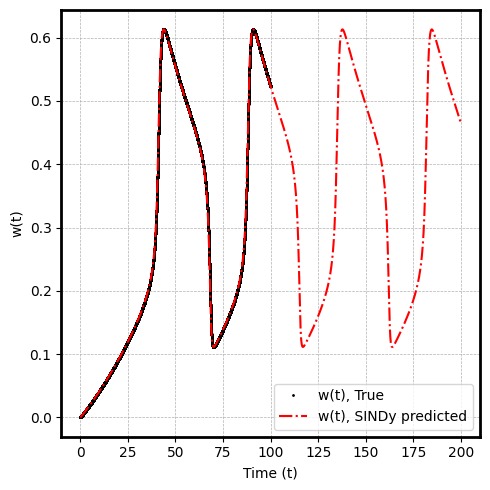

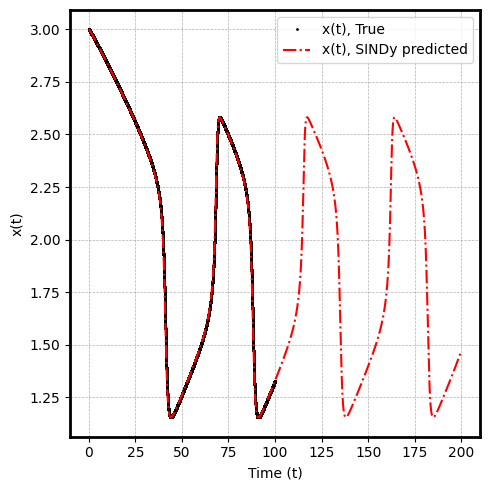

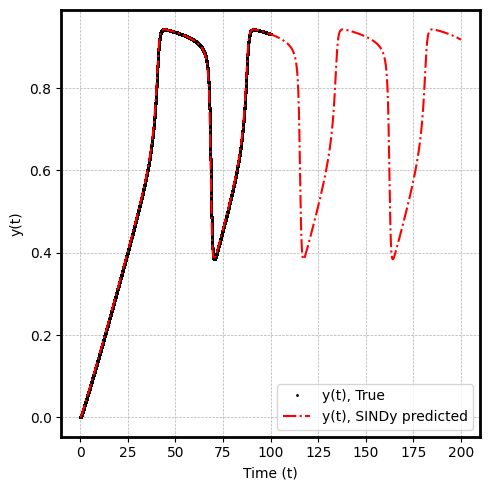

In [27]:
# Time-series plots
# u(t)
fig_u, ax_u = plt.subplots(figsize=(5, 5), dpi=100)
ax_u.plot(t_train, x_train[:, 0], 'k.', label='u(t), True', markersize=2)
ax_u.plot(forward_time, x_train_simulated_forward[:, 0], 'r-.',
          label='u(t), SINDy predicted', linewidth=1.5)
ax_u.set(xlabel='Time (t)', ylabel='u(t)')
ax_u.grid(True, which='both', ls='--', lw=0.5)
ax_u.legend()
set_spines_black(ax_u)
fig_u.tight_layout()
plt.show()


# v(t)
fig_v, ax_v = plt.subplots(figsize=(5, 5), dpi=100)
ax_v.plot(t_train, x_train[:, 1], 'k.', label='v(t), True', markersize=2)
ax_v.plot(forward_time, x_train_simulated_forward[:, 1], 'r-.',
          label='v(t), SINDy predicted', linewidth=1.5)
ax_v.set(xlabel='Time (t)', ylabel='v(t)')
ax_v.grid(True, which='both', ls='--', lw=0.5)
ax_v.legend()
set_spines_black(ax_v)
fig_v.tight_layout()
plt.show()


# w(t)
fig_w, ax_w = plt.subplots(figsize=(5, 5), dpi=100)
ax_w.plot(t_train, x_train[:, 2], 'k.', label='w(t), True', markersize=2)
ax_w.plot(forward_time, x_train_simulated_forward[:, 2], 'r-.',
          label='w(t), SINDy predicted', linewidth=1.5)
ax_w.set(xlabel='Time (t)', ylabel='w(t)')
ax_w.grid(True, which='both', ls='--', lw=0.5)
ax_w.legend()
set_spines_black(ax_w)
fig_w.tight_layout()
plt.show()


# x(t)
fig_x, ax_x = plt.subplots(figsize=(5, 5), dpi=100)
ax_x.plot(t_train, x_train[:, 3], 'k.', label='x(t), True', markersize=2)
ax_x.plot(forward_time, x_train_simulated_forward[:, 3], 'r-.',
          label='x(t), SINDy predicted', linewidth=1.5)
ax_x.set(xlabel='Time (t)', ylabel='x(t)')
ax_x.grid(True, which='both', ls='--', lw=0.5)
ax_x.legend()
set_spines_black(ax_x)
fig_x.tight_layout()
plt.show()


# y(t)
fig_y, ax_y = plt.subplots(figsize=(5, 5), dpi=100)
ax_y.plot(t_train, x_train[:, 4], 'k.', label='y(t), True', markersize=2)
ax_y.plot(forward_time, x_train_simulated_forward[:, 4], 'r-.',
          label='y(t), SINDy predicted', linewidth=1.5)
ax_y.set(xlabel='Time (t)', ylabel='y(t)')
ax_y.grid(True, which='both', ls='--', lw=0.5)
ax_y.legend()
set_spines_black(ax_y)
fig_y.tight_layout()
plt.show()


# **Interaction Network using Jacobian**

In [28]:
feature_names = model.get_feature_names()
coeffs = model.coefficients()

# Create symbolic expressions
du_dt = build_symbolic_rhs(coeffs[0], feature_names)
dv_dt = build_symbolic_rhs(coeffs[1], feature_names)
dw_dt = build_symbolic_rhs(coeffs[2], feature_names)
dx_dt = build_symbolic_rhs(coeffs[3], feature_names)
dy_dt = build_symbolic_rhs(coeffs[4], feature_names)

In [29]:
from sympy import lambdify
f_numeric = lambdify(
    (u, v, w, x, y),
    (du_dt, dv_dt, dw_dt, dx_dt, dy_dt),
    modules='numpy'
)

# Steady_states function
def system_func(vars):
    u_val, v_val, w_val, x_val, y_val = vars
    return f_numeric(u_val, v_val, w_val, x_val, y_val)

# Find steady states
steady_states = find_steady_states(
    system_func,
    num_vars=5,
    num_samples=5000,
    tol=1e-8,
    domain=[(0, 5), (0, 50), (0, 5), (0, 5), (0, 5)]
)

print("Steady states for the given system are:")
for i, (u_ss, v_ss, w_ss, x_ss, y_ss) in enumerate(steady_states, start=1):
    u_val = sp.N(u_ss, 3)
    v_val = sp.N(v_ss, 3)
    w_val = sp.N(w_ss, 3)
    x_val = sp.N(x_ss, 3)
    y_val = sp.N(y_ss, 3)
    print(
        f"  Steady state {i}: "
        f"(u, v, w, x, y) = "
        f"({u_val}, {v_val}, {w_val}, {x_val}, {y_val})"
    )

Steady states for the given system are:
  Steady state 1: (u, v, w, x, y) = (0.501, 29.9, 0.386, 1.71, 0.881)


In [30]:
# Define the Jacobian matrix
vars = sp.Matrix([u, v, w, x, y])
f = sp.Matrix([du_dt, dv_dt, dw_dt, dx_dt, dy_dt])
J = f.jacobian(vars).applyfunc(lambda expr: expr.evalf(3))

print("\nJacobian matrix:")
display(J)


Jacobian matrix:


Matrix([
[-0.4*v + 100.0*y - 100.0,   0.4 - 0.4*u,                       0,               0,                   100.0*u],
[                  -0.1*v,        -0.1*u,                       0,               0,                         0],
[                       0, 0.05 - 0.05*w, -0.05*v + 20.0*y - 20.0,               0,                    20.0*w],
[                       0,             0,                  -6.0*x,          -6.0*w,                       4.5],
[                       0,             0,                       0, 100.0*y - 100.0, 100.0*x + 200.0*y - 406.0]])

In [31]:
# Evaluate the Jacobian at steady state 1
J_evaluated = J.subs({u:steady_states[0][0],
                      v:steady_states[0][1],
                      w:steady_states[0][2],
                      x:steady_states[0][3],
                      y:steady_states[0][4]}).evalf(3)
display(J_evaluated)

Matrix([
[-23.9,     0.2,     0,     0,  50.1],
[-2.99, -0.0501,     0,     0,     0],
[    0,  0.0307, -3.88,     0,  7.71],
[    0,       0, -10.3, -2.31,   4.5],
[    0,       0,     0, -11.9, -58.0]])

In [32]:
eigs = J_evaluated.eigenvals() 
print("Eigenvalues at steady state 1:")
for ev, mult in eigs.items():
    print(f"  {N(ev,3)}  (multiplicity {mult})")

Eigenvalues at steady state 1:
  -23.9  (multiplicity 1)
  0.0448  (multiplicity 1)
  0.366  (multiplicity 1)
  -8.00  (multiplicity 1)
  -56.7  (multiplicity 1)



The Interaction Network corresponding to this Jacobian Matrix is:


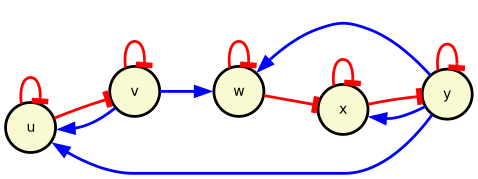

In [33]:
# Define the Jacobian matrix
nodes = ["u","v","w","x","y"]
jacobian_matrix = np.array(J_evaluated.tolist(), dtype=float)
# Draw the network
graph = draw_network(jacobian_matrix,
                     nodes,
                     output_path='MassAction_SINDy',
                     label_fontsize=10,
                     graph_size='10,10',
                    dpi =100)
# Display the generated PNG
print(f"\nThe Interaction Network corresponding to this Jacobian Matrix is:")
Image(filename='MassAction_SINDy.png')

In [34]:
#***************************************************************************************************************************************